In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [42]:
# --- Baca dataset ---
df = pd.read_csv('kematangan_buah.csv')
df.head()

,warna,tekstur,aroma,kematangan_fuzzy,kategori_kematangan
0,6,9,2,5.666122,Setengah Matang
1,3,6,1,3.635080,Setengah Matang
2,10,9,4,8.167628,Matang
3,7,8,9,8.122665,Matang
4,4,6,5,4.450924,Setengah Matang


In [44]:
# --- Definisi Variabel Fuzzy ---
warna = ctrl.Antecedent(np.linspace(0, 10, 101), 'warna')
tekstur = ctrl.Antecedent(np.linspace(0, 10, 101), 'tekstur')
aroma = ctrl.Antecedent(np.linspace(0, 10, 101), 'aroma')

kematangan = ctrl.Consequent(np.linspace(0, 10, 101), 'kematangan')

In [45]:
# --- Membership Function ---
warna['mentah'] = fuzz.trimf(warna.universe, [0, 0, 4])
warna['setengah_matang'] = fuzz.trimf(warna.universe, [3, 5, 7])
warna['matang'] = fuzz.trimf(warna.universe, [6, 10, 10])

tekstur['keras'] = fuzz.trimf(tekstur.universe, [0, 0, 4])
tekstur['sedang'] = fuzz.trimf(tekstur.universe, [3, 5, 7])
tekstur['lunak'] = fuzz.trimf(tekstur.universe, [6, 10, 10])

aroma['lemah'] = fuzz.trimf(aroma.universe, [0, 0, 4])
aroma['sedang'] = fuzz.trimf(aroma.universe, [3, 5, 7])
aroma['kuat'] = fuzz.trimf(aroma.universe, [6, 10, 10])

kematangan['mentah'] = fuzz.trimf(kematangan.universe, [0, 0, 4])
kematangan['setengah_matang'] = fuzz.trimf(kematangan.universe, [3, 5, 7])
kematangan['matang'] = fuzz.trimf(kematangan.universe, [6, 10, 10])

D:\Anaconda\envs\lab_ai\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


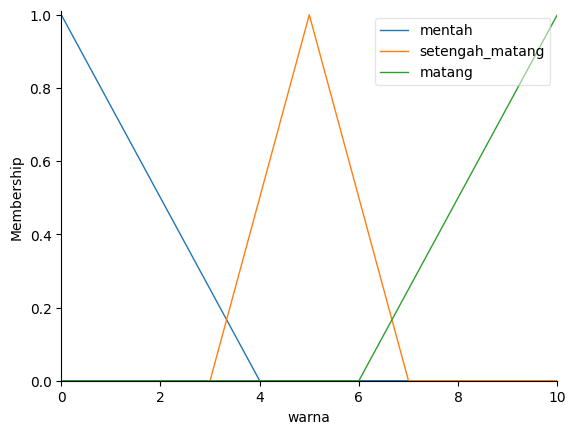

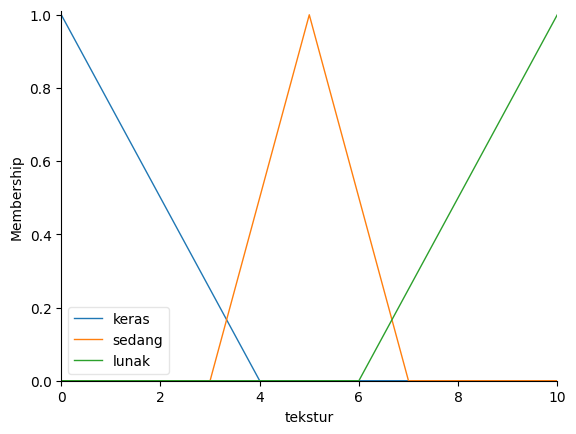

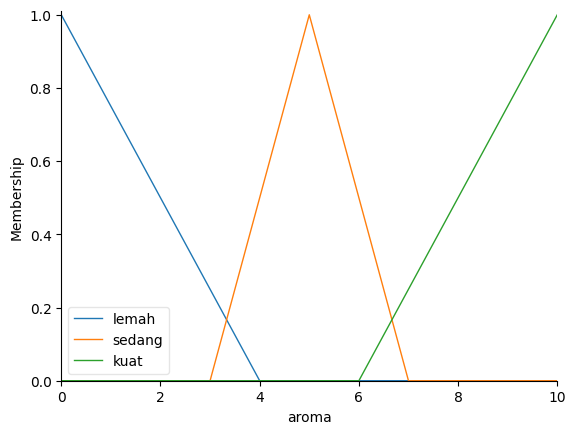

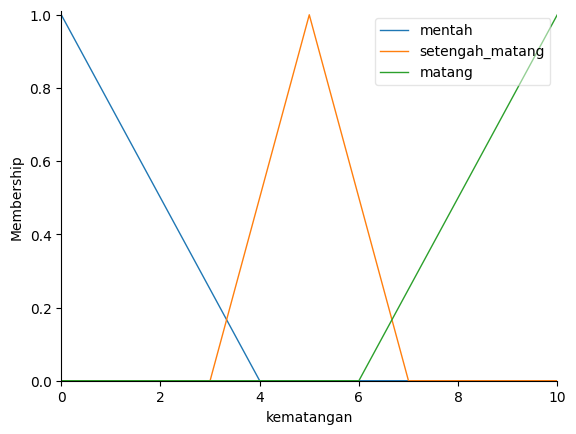

In [46]:
# --- Visualisasi Membership Function ---
warna.view()
tekstur.view()
aroma.view()
kematangan.view()

plt.show()


In [47]:
# --- Definisi Aturan (Rule Base) ---
W, T, A, K = warna, tekstur, aroma, kematangan
rules = [

    # Mentah
    ctrl.Rule(W['mentah'] & T['keras'] & A['lemah'], K['mentah']),
    ctrl.Rule(W['mentah'] & T['keras'] & A['sedang'], K['mentah']),
    ctrl.Rule(W['mentah'] & T['sedang'] & A['lemah'], K['mentah']),

    # Setengah matang (perpindahan fase)
    ctrl.Rule(W['mentah'] & T['sedang'] & A['sedang'], K['setengah_matang']),
    ctrl.Rule(W['setengah_matang'] & T['keras'] & A['lemah'], K['setengah_matang']),
    ctrl.Rule(W['setengah_matang'] & T['sedang'] & A['sedang'], K['setengah_matang']),
    ctrl.Rule(W['setengah_matang'] & T['lunak'] & A['kuat'], K['setengah_matang']),
    ctrl.Rule(W['matang'] & T['keras'] & A['sedang'], K['setengah_matang']),
    ctrl.Rule(W['matang'] & T['sedang'] & A['lemah'], K['setengah_matang']),

    # Matang
    ctrl.Rule(W['matang'] & T['lunak'] & A['kuat'], K['matang']),
    ctrl.Rule(W['matang'] & T['lunak'] & A['sedang'], K['matang']),
    ctrl.Rule(W['setengah_matang'] & T['lunak'] & A['kuat'], K['matang']),
    ctrl.Rule(W['matang'] & T['sedang'] & A['kuat'], K['matang']),
    ctrl.Rule(W['setengah_matang'] & T['sedang'] & A['kuat'], K['matang']),

    # Default fallback (biar gak error)
    ctrl.Rule(W['setengah_matang'] | T['sedang'] | A['sedang'], K['setengah_matang'])
]


In [49]:
# --- Bangun Sistem Fuzzy ---
fruit_ctrl = ctrl.ControlSystem(rules)
fruit_sim = ctrl.ControlSystemSimulation(fruit_ctrl)

In [50]:
# --- Fungsi Simulasi ---
def simulate_ripeness(warna_val, tekstur_val, aroma_val):
    fruit_sim.input['warna'] = float(warna_val)
    fruit_sim.input['tekstur'] = float(tekstur_val)
    fruit_sim.input['aroma'] = float(aroma_val)
    fruit_sim.compute()
    return fruit_sim.output['kematangan']


In [51]:
# --- Proses Dataset ---
def process_csv(input_path, output_path):
    df = pd.read_csv(input_path)
    hasil = []
    for _, row in df.iterrows():
        try:
            score = simulate_ripeness(row['warna'], row['tekstur'], row['aroma'])
        except:
            score = np.nan
        
        if np.isnan(score):
            kategori = 'Tidak Diketahui'
        elif score < 3.5:
            kategori = 'Mentah'
        elif score < 6.5:
            kategori = 'Setengah Matang'
        else:
            kategori = 'Matang'
        hasil.append([round(score, 2), kategori])
    
    df[['kematangan_fuzzy', 'kategori_kematangan']] = hasil
    df.to_csv(output_path, index=False)
    print(f"✅ Data berhasil diproses dan disimpan ke {output_path}")


In [52]:
# Jalankan
process_csv('kematangan_buah.csv', 'kematangan_output.csv')

# --- Analisis Hasil ---
df_out = pd.read_csv('kematangan_output.csv')


✅ Data berhasil diproses dan disimpan ke kematangan_output.csv


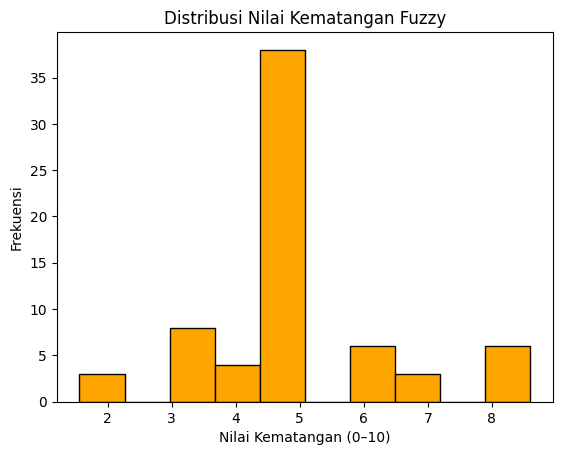

In [53]:
# 1️⃣ Histogram nilai fuzzy
plt.figure()
plt.hist(df_out['kematangan_fuzzy'].dropna(), bins=10, color='orange', edgecolor='black')
plt.title('Distribusi Nilai Kematangan Fuzzy')
plt.xlabel('Nilai Kematangan (0–10)')
plt.ylabel('Frekuensi')
plt.show()

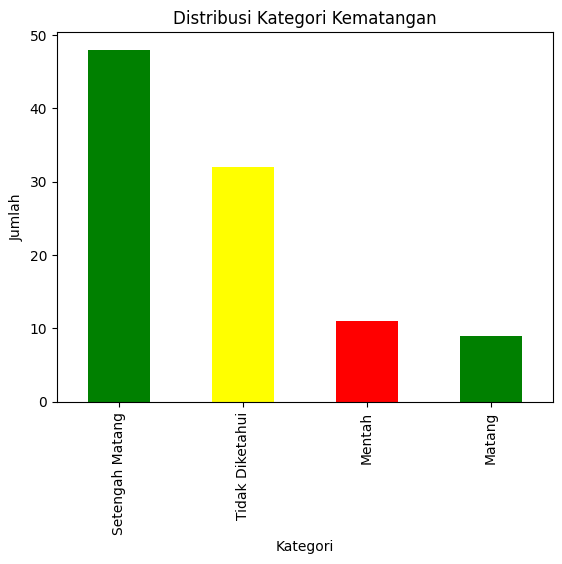

In [54]:
# 2️⃣ Bar chart kategori
plt.figure()
df_out['kategori_kematangan'].value_counts().plot(kind='bar', color=['green', 'yellow', 'red'])
plt.title('Distribusi Kategori Kematangan')
plt.xlabel('Kategori')
plt.ylabel('Jumlah')
plt.show()


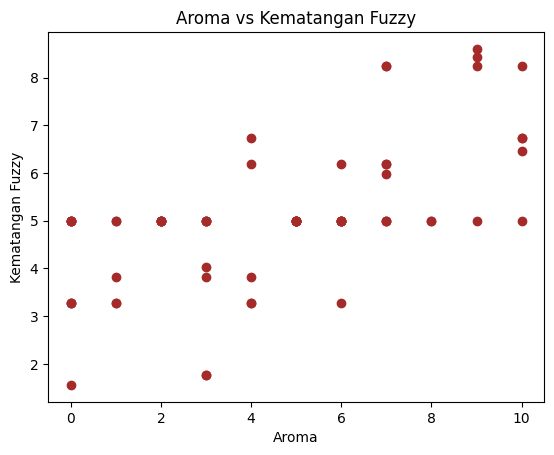

In [55]:
# 3️⃣ Scatter hubungan aroma vs kematangan
plt.figure()
plt.scatter(df_out['aroma'], df_out['kematangan_fuzzy'], color='brown')
plt.title('Aroma vs Kematangan Fuzzy')
plt.xlabel('Aroma')
plt.ylabel('Kematangan Fuzzy')
plt.show()

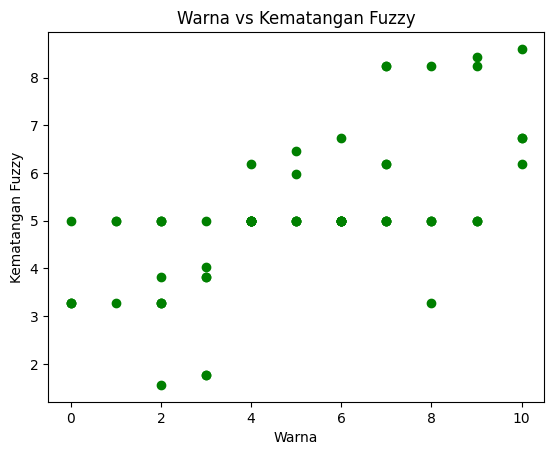

In [56]:
# 4️⃣ Scatter warna vs kematangan
plt.figure()
plt.scatter(df_out['warna'], df_out['kematangan_fuzzy'], color='green')
plt.title('Warna vs Kematangan Fuzzy')
plt.xlabel('Warna')
plt.ylabel('Kematangan Fuzzy')
plt.show()